# Modeling with Balanced Classes


## Table of Contents
- Sampling
-  Modeling 
- Conclusion

for this note book I will run the same models but instead of having 5 classes I will have 2 classes
- positive DR (0)
- Negatiive DR (1)

In [1]:
# Importing the required Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import cv2 as cv2
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# reading The saved daaframe that was created in the EDA and unbalanced class models
retina_df = pd.read_csv('retina_df.csv')


Changing the Level column into binary for Validation, test, and training sets.
- replacing all the classes from 1-4 to 1.
- keeping class 0 as 0.

In [3]:
# Binarizing the labels for the data
retina_df['level'] = np.where(retina_df['level'] > 0, 1 ,0 )


In [4]:
# sanity Check
retina_df['level'].unique()

array([0, 1])

Plotting the binary classes to see the frequency.

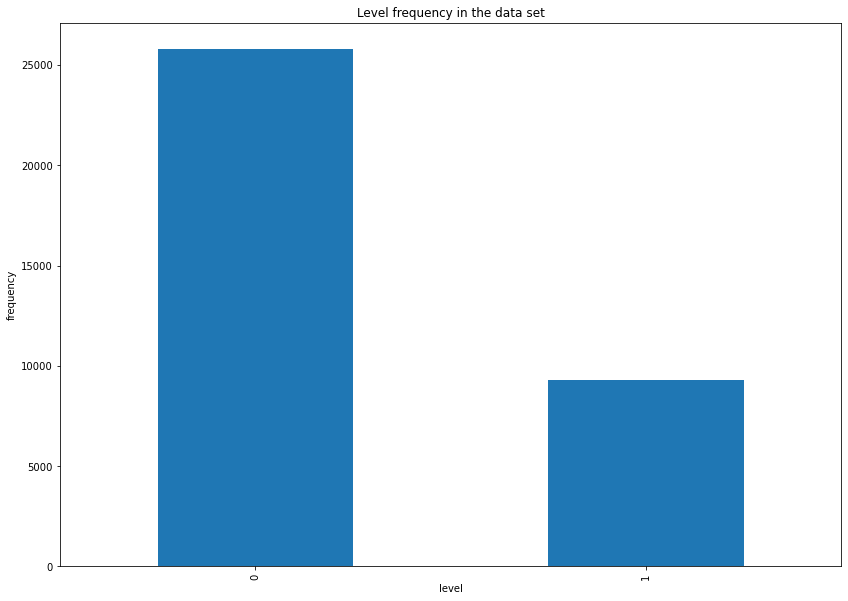

level
0    73.478335
1    26.521665
Name: level, dtype: float64


In [5]:
# plotting the frequency of my classes
plt.figure(figsize = (14,10))
retina_df.groupby('level')['level'].count().plot(kind = 'bar')

plt.ylabel('frequency')
plt.title('Level frequency in the data set')
plt.show()
print(retina_df.groupby('level')['level'].count()/35126*100)

the Negative DR is actually 3 times the size of the positive DR
this means I will add a class weight to the model to make them learn more from the postive class.

## Sampling the data
- split the data into remaining and test set 
- splitting the remaining data into training and validation set to perform Model training.
#### Important notes
- I have used the same Random state meaning that this sample will be identical to the samples I took from the other notebooks.

In [6]:
# splitting the data while making sure patients have both eyes in all sets
rem, test = next(GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7).split(retina_df, groups=retina_df['Patient_id']))

rem_df = retina_df.iloc[rem]
test_df = retina_df.iloc[test]

In [7]:
# splitting the remaining sample into train and validation
train, validation = next(GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7).split(rem_df, groups=rem_df['Patient_id']))

train_df = rem_df.iloc[train]
validation_df = rem_df.iloc[validation]

#### taking a small sample of the Data to run the logestic and SVM models on. 
- running all the data require a lot of time and memory(150GB)
- Taking the Global histogram preprocessed images as their shape is 400*400 this way My features will be 2 times smaller than the colored ones.
- Second I tried different sample sizes until I landed on a 10% sample size that my Local Machine RAM can Handle.
  

In [14]:
# taking a sample of the main data frame while stratifying the target column
from sklearn.model_selection import train_test_split
retina_df_sample, sample_to_drop = train_test_split(retina_df, train_size=0.10, stratify=retina_df['level'], random_state=42)

In [15]:
# then splitting the small sample into rem and test sets
from sklearn.model_selection import train_test_split
rem, test = train_test_split(retina_df_sample, test_size=0.15, stratify=retina_df_sample['level'], random_state=42)

In [16]:
# check
print(rem.shape,test.shape)

(2985, 6) (527, 6)


In [17]:
y_test_sample = test['level']
y_rem = rem['level']

(2985,)

As i'm using the same sample from the notebook where I ran the models on Unbalanced data I can just load the Scaled featured engineered Data to run on my binary classification models

In [37]:
# to load the pickeled  PCA files
infile_rem = open('PCA_test_sample','rb')
X_rem_PCA = pickle.load(infile_rem)
infile_rem.close()

infile_test = open( 'PCA_rem_sample','rb')
X_test_PCA = pickle.load(infile_test)
infile_test.close()

In [38]:
print(X_test_PCA.shape)
print(X_rem_PCA.shape)

(527, 2634)
(2985, 2634)


### fitting my Binary class data to  Logistic regression Model
- optimizing for value of C.
- Using a liblinear Solver 
- max_iter of 2000
- using cross validation to find the best value of C.
- Adding a Class weights Balanced argument as my data is very imbalanced.

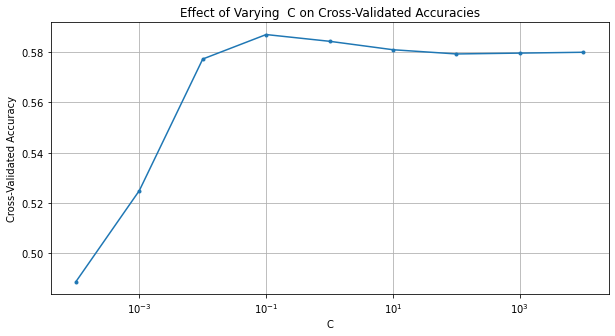

The best model has a depth =  0.1


In [39]:
# creating an empty list to append the validation scores to it
vc_acc_scores = []


# setting the values of C that I want to test
C_values = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000,10000]


for c in C_values:

    retina_logmodel_cv = LogisticRegression(solver='liblinear', C = c,max_iter=2000,class_weight='balanced' ).fit(X_rem_PCA, y_rem)

    
    #cross validation
    cv_accuracy = np.mean(cross_val_score(retina_logmodel_cv, X_rem_PCA, y_rem, cv=5, n_jobs=-1))
    vc_acc_scores.append(cv_accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(C_values, vc_acc_scores, marker = '.')
plt.title('Effect of Varying  C on Cross-Validated Accuracies')
plt.xscale('log') 
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()
which_vc = np.array(vc_acc_scores).argmax()

print("The best model has a depth = ",C_values[which_vc] )


Cross validation score peaked at almost 59% accuracy with a C value of 0.1. let's see how the model will perform on the test data

In [49]:
# fitting a logestic regression with C value of 0.01

retina_logmodel_cv = LogisticRegression(solver='liblinear', C = C_values[which_vc],max_iter=2000,class_weight='balanced' ).fit(X_rem_PCA, y_rem)
print(retina_logmodel_cv.score(X_test_PCA, y_test))
    # get predicted y values for the test set

test_score = retina_logmodel_cv.score(X_test_PCA, y_test)
y_pred = retina_logmodel_cv.predict(X_test_PCA)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# get target names
cols = y_test.unique()

# convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Negative DR", "Predicted Positive DR"],
    index=["True Negative DR", "True Positive DR"])


print(f'test accuracy is: {test_score}')
display(cf_df)

# Classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)



0.6660341555977229
test accuracy is: 0.6660341555977229


,Predicted Negative DR,Predicted Positive DR
True Negative DR,304,83
True Positive DR,93,47


              precision    recall  f1-score   support

           0       0.77      0.79      0.78       387
           1       0.36      0.34      0.35       140

    accuracy                           0.67       527
   macro avg       0.56      0.56      0.56       527
weighted avg       0.66      0.67      0.66       527



The models test accuracy is 66.6%.
- the recall for Negative DR is 79% while the recall for positive DR is only 34%
- the precision for negative DR is 77% while the precision for positive DR is 36%
- the F1 score for negative DR is 78% while the F1 score for positive DR is 35%.
- I can notice some improvement in predicting the Positive DR compared to the multi class data classification but It is still not good as I had many false positives. 

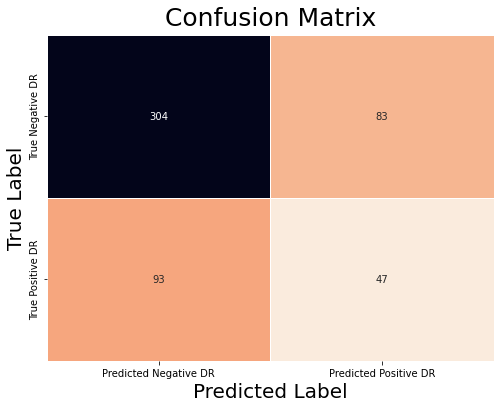

In [44]:
# plotting the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1,           
           )
plt.title('SVM Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

In the Confusion matrix above We notice that 67% from the positive DR were missclassified.
these results are still not quit good. Let's see how SVM will perform.

### Fitting imbalanced Data on Support Vector Machine
- performing cross validation to find the optimal Value of c_candidates
- adding a class_weight argument as Balanced this will allow my model to learn more from the minority classes.
- using the kernel rbf which is a non linear SVM and it can perform better classification. 

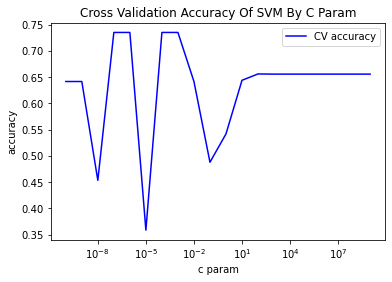

In [45]:
#
c_candidates = 10**np.arange(-10.0,10.0)

vc_acc = []


# need to loop through the hyperperameter C values to optimize the model

for c in c_candidates:
    
    SVM = SVC(C = c, kernel = 'rbf', class_weight='balanced')
    SVM.fit( X_rem_PCA,y_rem)
# Cross validation   
    cv_accuracy = np.mean(cross_val_score(SVM, X_rem_PCA, y_rem, cv=5, n_jobs=-1))
    vc_acc.append(cv_accuracy)
# plotting cross val acuracy
plt.figure()
plt.plot(c_candidates,vc_acc,c = 'blue',label = 'CV accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('c param')
plt.ylabel('accuracy')
plt.title('Cross Validation Accuracy Of SVM By C Param')
plt.show()

My cross validation accuracy fluctuated when the C value was less than 0,then flattened when it was 10 on 65%.
- the best score was for 0.001 and 0.00001 with 74% accuracy.
- I will use the C value of 0.001 to run the model on my test set Below

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SVM =SVC(C = 0.001, kernel = 'rbf', class_weight='balanced')
SVM.fit( X_rem_PCA,y_rem)
print(SVM.score(X_test_PCA, y_test))
    # get predicted y values for the test set

test_score = SVM.score(X_test_PCA, y_test)
y_pred = SVM.predict(X_test_PCA)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)



# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Negative DR", "Predicted Positive DR"],
    index=["True Negative DR", "True Positive DR"])
display(cf_df)

print(f'test accuracy is: {test_score}')


# Classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)


0.7343453510436433


,Predicted Negative DR,Predicted Positive DR
True Negative DR,387,0
True Positive DR,140,0


test accuracy is: 0.7343453510436433
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       387
           1       0.00      0.00      0.00       140

    accuracy                           0.73       527
   macro avg       0.37      0.50      0.42       527
weighted avg       0.54      0.73      0.62       527



C:\Users\zedal\anaconda3\envs\deeplearninggpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zedal\anaconda3\envs\deeplearninggpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zedal\anaconda3\envs\deeplearninggpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

SVM has scored 73% accuracy on the test set. but when looking at the confusion Matrix I notice that it mad one prediction to all Images Negative DR. 
I believe using a linear SVM would perform as good if not better than the logistic regression model.

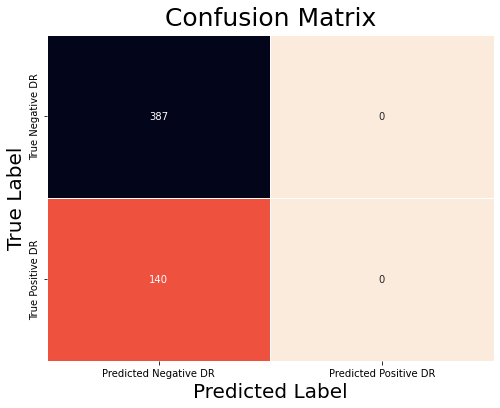

In [56]:
# creating a confusion Matrix for the SVM test results

plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
           )
plt.title('Confusion Matrix')
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)



plt.show()

## Transfer Learning model Resnet50
- as Resnet model performed the best between the other Transfer learning models I chose to use it for the Binary classification

I have to first change the classes type to string for ImageData Generator to read.

In [8]:
# changing the classes type to string in all my sets
train_df['level'] = train_df['level'].astype(str)
validation_df['level']= validation_df['level'].astype(str)
test_df['level']= test_df['level'].astype(str)

C:\Users\zedal\AppData\Local\Temp/ipykernel_4488/2107455302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['level'] = train_df['level'].astype(str)
C:\Users\zedal\AppData\Local\Temp/ipykernel_4488/2107455302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['level']= validation_df['level'].astype(str)
C:\Users\zedal\AppData\Local\Temp/ipykernel_4488/2107455302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

I created a function that blurs Images so i can perform as many different augmentations on my duplicated images to make them unique.

In [9]:
# BLURRING FUNCTION
def blur(img):
    ''' this function will blur the input Image and return it'''
    
    return (cv2.blur(img,(4,4)))

I will Be using Image Data generator to train my models using small batches.
Before Feeding Images into the model I will First need to perform:
- Image augmentation steps are applied (rotation, scaling, flipping,shear,Brightness adjustment,horizontal flip,vertical flip,blurring, rescaling and zooming) 
- I will rescale the validation data set as well
- My images will have a shape of 400*400 pixels and 3 channels.
- I will use the method flow from dataframe and specify the Path for the images and the target.
- this will allow my data generator to extract images from the directory and feed them to the model.
- I tried different Batch sizes and 75 was the biggest batch that My local gpu can handel.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# specifying the image hight width and channels
height = 400 
width = 400
channels = 3 
# applying random image augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 40,
                                   shear_range=0.2,
                                   zoom_range=0.15,
                                   brightness_range=[0.2,.5],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=blur
                                   )
# rescaling the validation images
Validation_datagen = ImageDataGenerator(rescale=1./255)
                                   
                                   
                                   
# geneerating my train data                                  
Train_df_gen = train_datagen.flow_from_dataframe(
    train_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = train_df['path'],
     class_mode='categorical', shuffle=True, target_size=(height,width),
                                                 
                                                 batch_size=75
                                                 
    
    
)
# generating my test data
Val_df_gen = Validation_datagen.flow_from_dataframe(
    validation_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = validation_df['path'],
     class_mode='categorical', batch_size=75, shuffle=True,target_size=(height,width)
                                                 
                                                 )

Found 25376 validated image filenames belonging to 2 classes.
Found 4480 validated image filenames belonging to 2 classes.


Here are 4 images from the validation set.

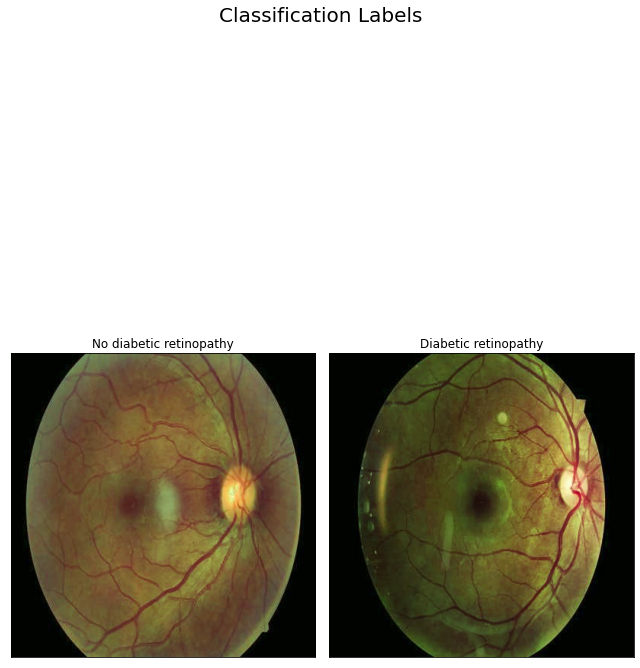

In [92]:
# Grab a batch of images from our validation generator: 
x, y = Val_df_gen.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

diabetes_levels = ['No diabetic retinopathy',
                     'Diabetic retinopathy']
                

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 14))
ax = ax.flatten()

for i in range(0,2):
    
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(diabetes_levels[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 20)
fig.tight_layout()

# Delete the two unused subplots
# fig.delaxes(ax[-1])
# fig.delaxes(ax[-2])

### RESNET50 MODEL
- I first will download RESNET50 model from the keras model Library.
- RESNET50 is a pre-trained model.
- I will use the top Layers of the RESNET50 model and specify the shape of my input.
- I'll freeze all the layers so that non of them are trainable.
- I will use the weights imagenet.

In [13]:
from tensorflow.keras.applications import ResNet50V2

model_resnet = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,3))
for layer in model_resnet.layers:
    layer.trainable = False
model_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

I will now add the last Layers. RESNET50 has 23,564,800 parameters, by freezing them they all become Non-trainable
- first i'll specify the the ResNet50V2 model output so that my layers will run after RESNET layers.
- then I will flatten the images 
- I will add some dense Layers this will use the features that were learned from the RESNET layers to make the final prediction.
- last I will add a softmax layer to make the prediction with 5 predictions (number of classes)
- I added a dropout Layer to prevent overfitting. 


In [14]:
from tensorflow.keras.models import Model

x = model_resnet.output 
x = Flatten()(x) 
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model_resnet = Model(inputs=model_resnet.input, 
              outputs=output)

As the classes are very unbalanced I chose to add a class weight to the model.  
I tried this method with the multi class but surprisingly it didn't work and the models performed really poor.

First I calculated the class weight for positive and negative and specified to be balanced. 
- then I turned it into a dictionary as the model requires the class weights to be in a dictionary 

In [63]:
from sklearn.utils import class_weight

# calculating class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(Train_df_gen.classes), y = Train_df_gen.classes) 

In [64]:
# turning class weights into a dictunary
class_weights = dict(enumerate(class_weights))

compiling the model I used Adam optimizer with learning rate of 0.001. the loss has to be categorical_crossentropy.
- fitting the model to the training and validation data
- I ran the model for 60 epochs. 
- I  used early stop for this model As I was aiming to prevent overfitting
- I saved the model history and the model weights.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import CSVLogger
# Save the history of the model to a pandas dataframe
csv_logger = CSVLogger("resnet_model_Binary_weighted_history_log.csv", append=True)


model_resnet.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', 
                           verbose=1)

resnet_history = model_resnet.fit(Train_df_gen,
          epochs=60,
          validation_data = Val_df_gen,
          callbacks=[csv_logger,early_stop],
          class_weight= class_weights)
          
model_name = 'my_model_resnet_weighted_binary.h5'
model_resnet.save(model_name)

In [9]:
# loading the model
resnet_model_binary_weighted  = tf.keras.models.load_model('my_model_resnet_weighted_binary.h5')

generating 400 images from the test data. and rescaling them

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = validation_df['path'],
     class_mode='categorical', batch_size=400, shuffle=True,target_size=(400,400))
                                                 

X_test, y_test = test_generator.next()

Found 5270 validated image filenames belonging to 2 classes.


In [11]:
# check
y_test.shape
X_test.shape

(400, 400, 400, 3)

Testing the accuracy, classification report, confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_test, y_test = test_generator.next()
score = resnet_model_binary_weighted.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Calculate the predictions
predict_probas = resnet_model_binary_weighted.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

y_test_labels = np.argmax(y_test, axis=1)
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test_labels, y_predict)
# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Negative DR", "Predicted Positive DR"],
    index=["True Negative DR", "True Positive DR"]
)
display(cf_df)

# Classification report
report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

13/13 [==============================] - 9s 327ms/step - loss: 0.6373 - accuracy: 0.7400
Test loss: 0.637263834476471
Test accuracy: 0.7400000095367432


,Predicted Negative DR,Predicted Positive DR
True Negative DR,233,50
True Positive DR,54,63


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       283
           1       0.56      0.54      0.55       117

    accuracy                           0.74       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.74      0.74      0.74       400



- The model performed well it scored 74% accuracy on 400 Images, the recall is 82% for Negative and 54 for positive. 
- the precision for negative is 81% while it's 56% for the positive.
- that means from 287 negative predicted results the model correctly predicted 233. 74% which is a good results considering the other models.


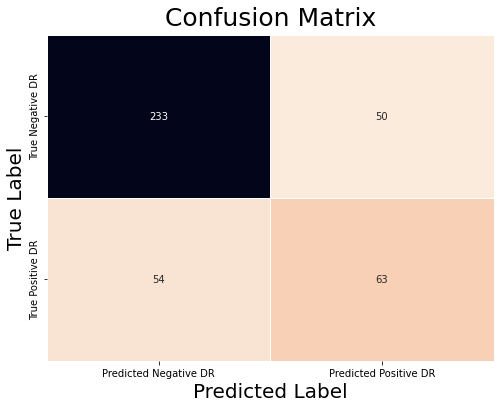

In [15]:
# plt.title('Confusion Matrix')
plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1   
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)



plt.show()

In [16]:
# Loading the model epochs
hist_df_new = pd.read_csv("resnet_model_Binary_weighted_history_log.csv")

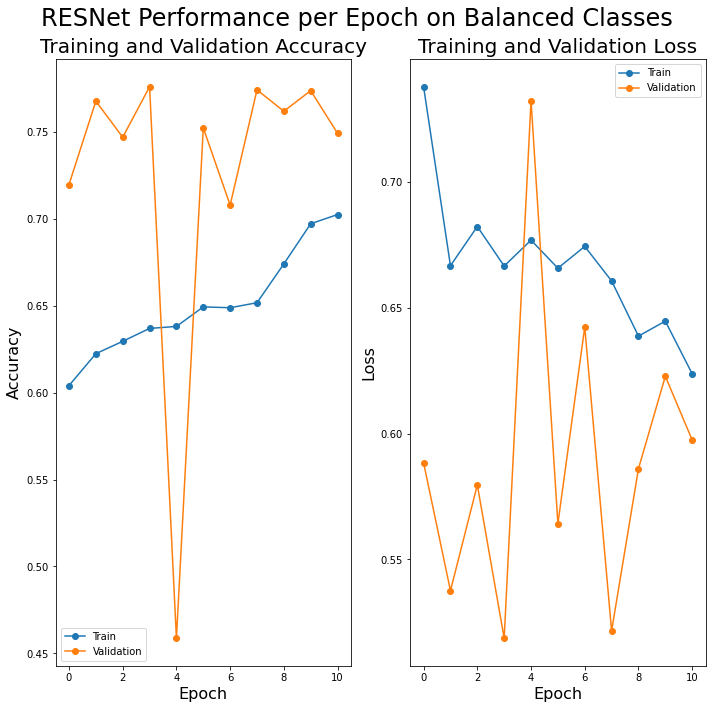

In [22]:
plt.subplots(1, 2, figsize=(10,10))

# Creates a title for the whole plot
plt.suptitle('RESNet Performance per Epoch on Balanced Classes', fontsize=24)

# Plot accuracies for train and validation sets
plt.subplot(1, 2, 1)
plt.plot(hist_df_new['accuracy'], label='Train', marker='o')
plt.plot(hist_df_new['val_accuracy'], label='Validation', marker='o')
plt.title('Training and Validation Accuracy', size=20)
plt.xlabel('Epoch', size=16)
plt.ylabel('Accuracy', size=16)
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(hist_df_new['loss'], label='Train', marker='o')
plt.plot(hist_df_new['val_loss'], label='Validation', marker='o')
plt.title('Training and Validation Loss', size=20)
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.legend()

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

Due to the Dropout and class weight the validation accuracy performed better than the training in this model it had one dip but it peeked to 77% 
same for the validation loss it dipped once but it performed better than the training loss.

Here are some of the misclassified images

IndexError: index 9 is out of bounds for axis 0 with size 9

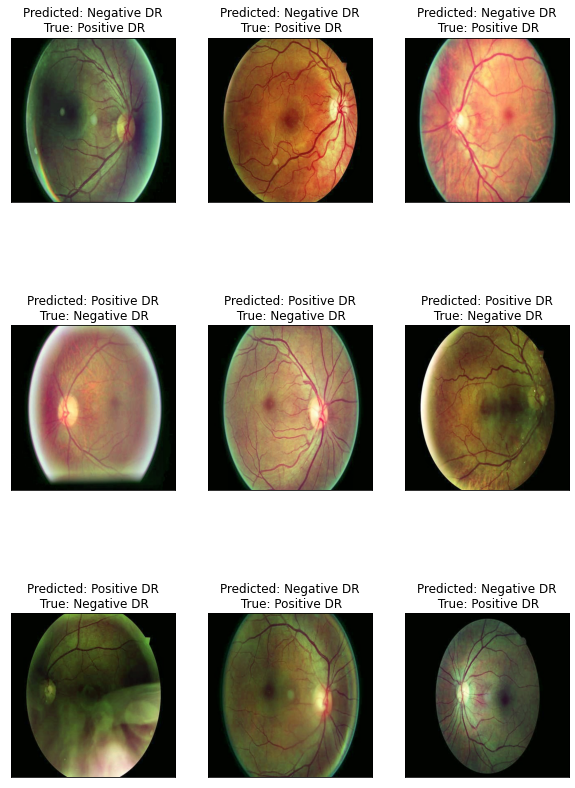

In [20]:
# Specify the levels
DR_levels = ['Negative DR', 'Positive DR',]
# specify the misclassified images
incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = 3
# create a subplot
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 5*rows))

axes = axes.flatten()
# loop through the misclassified images
for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    predicted_label = DR_levels[y_predict[incorrect_photos][i]]
    
    # Get actual label
    true_label =  DR_levels[y_test_labels[incorrect_photos][i]]
    
    # Set the title of the subplot
    axes[i].set_title(f"Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()

# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])


Most of the Images that got misclassified are actually underexposed or over

## Conclusion 
- Both models RESNET and Logistic Regression Performed Better when the Class was Binary in comparison to multiclass.  
- SVM didn't perform well a linear SVM could have improved better. 
- RESNET with Binary classes is a good model for people with diabeties but are Negative for DR. it will help them monitor if their eyes have developed DR with a not bad accuracy.  
- with better Preprocessing I can see the results getting a lot better.  

